## Dataset: Baseball Players
A couple notes about this lab:

Although it isn’t listed as a specific question, don’t forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?

There are a lot of variables in the dataset! You may want to use the remainder = "passthrough" trick in your column transformers, rather than typing out a ton of gene names.

Don’t forget that in penalized regression, we must standardize our numeric variables.

There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.

In [32]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error

In [17]:
data = pd.read_csv("/Users/owenk/OneDrive/Documents/GitHub/GSB_544_ML/Lab 6/Hitters.csv")
data_clean = data.dropna()
# dummify League, Division, and NewLeague 
data_clean.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


# Part I: Different Model Specs

A. Regression without regularization

1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

2. Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

3. Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [11]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
).set_output(transform  = "pandas")

#step 1
lr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("linear_regression", LinearRegression())]
).set_output(transform = "pandas")

In [22]:
#Step 2
X = data_clean.drop(["Salary"], axis = 1)
y = data_clean["Salary"]

X_test = ct.fit_transform(X)
X_test.head()

#len(X_test.columns)

,dummify__League_A,dummify__League_N,dummify__Division_E,dummify__Division_W,dummify__NewLeague_A,dummify__NewLeague_N,standardize__AtBat,standardize__Hits,standardize__HmRun,standardize__Runs,standardize__RBI,standardize__Walks,standardize__Years,standardize__CAtBat,standardize__CHits,standardize__CHmRun,standardize__CRuns,standardize__CRBI,standardize__CWalks,standardize__PutOuts,standardize__Assists,standardize__Errors
1,0.0,1.0,0.0,1.0,0.0,1.0,-0.602900,-0.595675,-0.528551,-1.206112,-0.522063,-0.097527,1.397893,0.346791,0.174373,-0.002920,-0.121671,0.258966,0.435334,1.221499,-0.523191,0.213352
2,1.0,0.0,0.0,1.0,1.0,0.0,0.512542,0.492260,0.729966,0.441515,0.794060,1.609373,-0.901200,-0.452865,-0.409892,-0.076054,-0.415105,-0.199590,0.010373,2.109109,-0.253863,0.819964
3,0.0,1.0,1.0,0.0,0.0,1.0,0.628167,0.736490,0.958788,0.402286,1.026317,-0.189792,0.770868,1.301558,1.318174,1.898565,1.412051,1.572666,0.355654,-0.324661,-0.744179,-0.848219
4,0.0,1.0,1.0,0.0,0.0,1.0,-0.562092,-0.462459,-0.185319,-0.617673,-0.367225,-0.512719,-1.110209,-0.990935,-0.960153,-0.697693,-0.947521,-0.881228,-0.862315,1.840678,-0.543909,-0.696566
5,1.0,0.0,0.0,1.0,1.0,0.0,1.294712,1.358167,-0.871783,0.755349,-0.018840,-0.282057,0.770868,0.766993,0.634985,-0.612370,0.422846,0.017294,-0.251434,-0.031177,2.087225,2.488147


In [16]:
lr_fit = lr_pipeline.fit(X, y)
lr_fit['linear_regression'].coef_

array([ -31.29971152,   31.29971152,   58.42462282,  -58.42462282,
         12.38116255,  -12.38116255, -291.0945557 ,  337.83047948,
         37.85383676,  -60.57247861,  -26.99498379,  135.07389695,
        -16.69335888, -391.03865466,   86.68761664,  -14.18172332,
        480.74713477,  260.68988581, -213.89225864,   78.76129639,
         53.73248973,  -22.16086217])

In [109]:
feature_labels = [
    'dummify__League_A', 'dummify__League_N', 'dummify__Division_E', 'dummify__Division_W',
    'dummify__NewLeague_A', 'dummify__NewLeague_N', 'standardize__AtBat', 'standardize__Hits',
    'standardize__HmRun', 'standardize__Runs', 'standardize__RBI', 'standardize__Walks',
    'standardize__Years', 'standardize__CAtBat', 'standardize__CHits', 'standardize__CHmRun',
    'standardize__CRuns', 'standardize__CRBI', 'standardize__CWalks', 'standardize__PutOuts',
    'standardize__Assists', 'standardize__Errors'
]

lr_coefficients = lr_fit['linear_regression'].coef_

lr_coef_df = pd.DataFrame({
    "Feature": feature_labels,
    "Coefficient": lr_coefficients
})

lr_coef_df = lr_coef_df.sort_values(by="Coefficient", ascending=False)
lr_coef_df

,Feature,Coefficient
16,standardize__CRuns,480.747135
7,standardize__Hits,337.830479
17,standardize__CRBI,260.689886
11,standardize__Walks,135.073897
14,standardize__CHits,86.687617
19,standardize__PutOuts,78.761296
2,dummify__Division_E,58.424623
20,standardize__Assists,53.732490
8,standardize__HmRun,37.853837
1,dummify__League_N,31.299712


A few of the most important coefficients here are on the explanatory variables AtBat, Walks, and CRuns. In this context, I am considering the most important coefficients to be those which have the highest effect on salary. 

As at bats in 1986 increase by 1, salary on average decreases by $291. 
As Hits in 1986 increase by 1, salary on average increases by $337.
As career at bats increase by 1, salary on average decreases by $391.
As career runs increase by 1, salary on average increases by $480.


In [37]:
#part 3
lrr2_cv = cross_val_score(lr_pipeline, X, y, cv = 5, scoring = "r2")
-lrr2_cv.mean()

-0.3434950217881677

In [111]:
lrmse_cv = cross_val_score(lr_pipeline, X, y, cv=5, scoring="neg_mean_squared_error")
-lrmse_cv.mean()

121136.3103181688

The R2 and MSE scores from above indicate that this linear regession model does not effectively explain the variance in salary, and is not a good fit.

B. Ridge regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the 
 hyperparameter.

3. Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [51]:
#Step 1
rr_pipeline = Pipeline(
  [("preprocessing", ct),
  ("ridge_regression", Ridge())]
).set_output(transform = "pandas")

In [66]:
#Step 2
param_grid = {
    "ridge_regression__alpha": [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000]
}

rr_grid_search = GridSearchCV(rr_pipeline, param_grid, cv=5, scoring='r2')

rr_grid_search.fit(X, y)
print("best_params", rr_grid_search.best_params_)

best_params {'ridge_regression__alpha': 100}
best_params {'ridge_regression__alpha': 100}


In [68]:
#Step 3
rr_pipeline.set_params(ridge_regression__alpha = 100)
rr_fit = rr_pipeline.fit(X, y)
rr_fit['ridge_regression'].coef_

array([-11.05184162,  11.05184162,  38.02322237, -38.02322237,  -4.09159035,
         4.09159035,  -0.56737013,  49.6123856 ,  -1.4641586 ,  29.34326268,
        22.95801548,  41.38461684,  -2.7083058 ,  24.70584373,  44.53427648,
        38.6853297 ,  45.5076061 ,  47.1455561 ,   4.03637066,  56.88152161,
         7.45723865, -13.38238979])

In [73]:
feature_labels = [
    'dummify__League_A', 'dummify__League_N', 'dummify__Division_E', 'dummify__Division_W',
    'dummify__NewLeague_A', 'dummify__NewLeague_N', 'standardize__AtBat', 'standardize__Hits',
    'standardize__HmRun', 'standardize__Runs', 'standardize__RBI', 'standardize__Walks',
    'standardize__Years', 'standardize__CAtBat', 'standardize__CHits', 'standardize__CHmRun',
    'standardize__CRuns', 'standardize__CRBI', 'standardize__CWalks', 'standardize__PutOuts',
    'standardize__Assists', 'standardize__Errors'
]

rr_coefficients = rr_fit['ridge_regression'].coef_

rr_coef_df = pd.DataFrame({
    "Feature": feature_labels,
    "Coefficient": rr_coefficients
})

rr_coef_df = rr_coef_df.sort_values(by="Coefficient", ascending=False)
rr_coef_df

,Feature,Coefficient
19,standardize__PutOuts,56.881522
7,standardize__Hits,49.612386
17,standardize__CRBI,47.145556
16,standardize__CRuns,45.507606
14,standardize__CHits,44.534276
11,standardize__Walks,41.384617
15,standardize__CHmRun,38.685330
2,dummify__Division_E,38.023222
9,standardize__Runs,29.343263
13,standardize__CAtBat,24.705844


Most important coefficients are:
PutOuts

Hits

CRBI

CRuns

Walks


In [74]:
#Step 4
rrmse_cv = cross_val_score(rr_fit, X, y, cv=5, scoring="neg_mean_squared_error")
-rrmse_cv.mean()

120716.43558937623

## C. Lasso Regression
1. Create a pipeline that includes all the columns as predictors for Salary, and performs lasso regression

2. Use cross-validation to tune the 
 hyperparameter.

3. Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [75]:
#step 1
lasso_pipeline = Pipeline(
  [("preprocessing", ct),
  ("lasso_regression", Lasso())]
).set_output(transform = "pandas")

In [78]:
#Step 2 
param_grid1 = {
    "lasso_regression__alpha": [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000]
}
grid_search1 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring='r2')
grid_search1.fit(X, y)
print("best_params", grid_search1.best_params_)

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.004e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.984e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.012e+07, toleranc

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.471e+05, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.066e+06, tolerance: 4.558e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e+04, toleranc

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.815e+03, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(


best_params {'lasso_regression__alpha': 10}
best_params {'lasso_regression__alpha': 10}


In [79]:
#Step 3 
lasso_pipeline.set_params(lasso_regression__alpha = 10)
lasso_fit = lasso_pipeline.fit(X, y)
lasso_fit['lasso_regression'].coef_


array([-0.00000000e+00,  0.00000000e+00,  9.54132032e+01, -3.29335366e-12,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  8.87416269e+01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.99028129e+01,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        7.22275293e+01,  1.34032027e+02, -0.00000000e+00,  6.67370055e+01,
        0.00000000e+00, -4.15828061e+00])

In [80]:
lasso_coefficients = lasso_fit['lasso_regression'].coef_
lasso_coef_df = pd.DataFrame({
    "Feature": feature_labels,
    "Coefficient": lasso_coefficients
})

lasso_coef_df = lasso_coef_df.sort_values(by="Coefficient", ascending=False)
lasso_coef_df

,Feature,Coefficient
17,standardize__CRBI,1.340320e+02
2,dummify__Division_E,9.541320e+01
7,standardize__Hits,8.874163e+01
16,standardize__CRuns,7.222753e+01
19,standardize__PutOuts,6.673701e+01
11,standardize__Walks,4.990281e+01
12,standardize__Years,-0.000000e+00
20,standardize__Assists,0.000000e+00
18,standardize__CWalks,-0.000000e+00
15,standardize__CHmRun,0.000000e+00


Most important lasso coeffiecients: 

Division W

CRBI 

Division E 

Hits

CRuns

In [81]:
#Step 4 
lassomse_cv = cross_val_score(lasso_fit, X, y, cv=5, scoring="neg_mean_squared_error")
-lassomse_cv.mean()

121828.14133338635

## D. Elastic Net
1. Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

2. Use cross-validation to tune the lambda and alpha hyperparameters.

3. Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

4. Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [92]:
#Step 1
elastic_net_pipeline = Pipeline(
  [("preprocessing", ct),
  ("elastic_net", ElasticNet())]
).set_output(transform = "pandas")

In [100]:
#Step 2
param_grid3 = {
    "elastic_net__alpha": [0.001, 0.01, 0.1, 1, 10, 50, 100, 500, 1000],
    "elastic_net__l1_ratio": [.2, .5, .8]
}
grid_search3 = GridSearchCV(elastic_net_pipeline, param_grid3, cv=5, scoring='r2')
grid_search3.fit(X, y)
print("best_params", grid_search3.best_params_)

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+07, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.075e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.025e+07, toleranc

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.018e+07, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.060e+06, tolerance: 4.281e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.579e+06, toleranc

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.981e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.014e+07, tolerance: 4.137e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.525e+06, toleranc

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e+05, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.634e+04, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.792e+05, toleranc

best_params {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.2}
best_params {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.2}


In [106]:
#Step 3
elastic_net_pipeline.set_params(elastic_net__alpha=1, elastic_net__l1_ratio=0.2)
en_fit = elastic_net_pipeline.fit(X, y)
en_fit['elastic_net'].coef_

array([ -7.24856851,   7.24859489,  26.10398424, -26.10397086,  -4.11652343,
         4.11654601,  12.17941865,  37.45066774,   5.60999921,  27.01102791,
        22.98319164,  34.56856302,   7.63421154,  25.86740349,  36.12482194,
        32.31244032,  36.94311439,  37.88046512,  15.35577323,  44.83514184,
         3.83655838,  -8.0361849 ])

In [107]:
en_coefficients = en_fit['elastic_net'].coef_

en_coef_df = pd.DataFrame({
    "Feature": feature_labels,
    "Coefficient": en_coefficients
})

en_coef_df = en_coef_df.sort_values(by="Coefficient", ascending=False)
en_coef_df

,Feature,Coefficient
19,standardize__PutOuts,44.835142
17,standardize__CRBI,37.880465
7,standardize__Hits,37.450668
16,standardize__CRuns,36.943114
14,standardize__CHits,36.124822
11,standardize__Walks,34.568563
15,standardize__CHmRun,32.312440
9,standardize__Runs,27.011028
2,dummify__Division_E,26.103984
13,standardize__CAtBat,25.867403


Elastic Net most Important variables: 

PutOuts

Hits

CRBI

CRuns

CHits

In [108]:
#Step 4
enmse_cv = cross_val_score(en_fit, X, y, cv=5, scoring="neg_mean_squared_error")
-enmse_cv.mean()

121500.81646251371

## Part II. Variable Selection
Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important

Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

1. Using only the one best numeric variable.

2. Using only the five best variables.

3. Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: lambda and alpha must be re-tuned for each feature set.)

The common most important variable from the above models is CRuns, based on model validity and magnitude.

5 most important numeric variables:

CRuns

Hits

CRBI

CHits

Walks

Most important categorical variable is Division (E vs W)

#### 1 numerical variable 


In [117]:
#step 1 
X1 = data_clean[["CRuns"]]
y1 = data_clean["Salary"]


In [120]:
#Linear Regression

lr_fit2 = lr_pipeline.fit(X1, y1)
lr_fit2['linear_regression'].coef_
lr2mse_cv = cross_val_score(lr_pipeline, X1, y1, cv=5, scoring="neg_mean_squared_error")
-lr2mse_cv.mean()

143812.93591629737

In [121]:
# Ridge Regression 

rr_grid_search2 = GridSearchCV(rr_pipeline, param_grid, cv=5, scoring='r2')

rr_grid_search2.fit(X1, y1)
print("best_params", rr_grid_search2.best_params_)

best_params {'ridge_regression__alpha': 10}
best_params {'ridge_regression__alpha': 10}


In [125]:
rr_pipeline.set_params(ridge_regression__alpha = 10)
rr_fit2 = rr_pipeline.fit(X1, y1)
rr_fit2['ridge_regression'].coef_
rrmse_cv2 = cross_val_score(rr_fit2, X1, y1, cv=5, scoring="neg_mean_squared_error")
-rrmse_cv2.mean()

143658.5173685888

In [124]:
#Lasso Regression 

lasso_grid_search2 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring='r2')
lasso_grid_search2.fit(X1, y1)
print("best_params", lasso_grid_search2.best_params_)


best_params {'lasso_regression__alpha': 10}
best_params {'lasso_regression__alpha': 10}


In [126]:
lasso_pipeline.set_params(lasso_regression__alpha = 10)
lasso_fit2 = lasso_pipeline.fit(X1, y1)
lasso_fit2['lasso_regression'].coef_
lassomse_cv2 = cross_val_score(lasso_fit2, X1, y1, cv=5, scoring="neg_mean_squared_error")
-lassomse_cv2.mean()

143793.4491585397

In [127]:
#Elastic Net 
en_grid_search2 = GridSearchCV(elastic_net_pipeline, param_grid3, cv=5, scoring='r2')
en_grid_search2.fit(X1, y1)
print("best_params", en_grid_search2.best_params_)

best_params {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.5}
best_params {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 0.5}


In [129]:
elastic_net_pipeline.set_params(elastic_net__alpha=.1, elastic_net__l1_ratio=0.5)
en_fit2 = elastic_net_pipeline.fit(X1, y1)
en_fit2['elastic_net'].coef_
enmse_cv2 = cross_val_score(en_fit2, X1, y1, cv=5, scoring="neg_mean_squared_error")
-enmse_cv2.mean()

143655.07604766646

#### 5 Numerical Varaibles

In [130]:
#Step 2
X2 = data_clean[["CRuns", "Hits", "CRBI", "CHits", "Walks"]]
y2 = data_clean["Salary"]

In [131]:
#Linear Regression 
lr_fit3 = lr_pipeline.fit(X2, y2)
lr_fit3['linear_regression'].coef_
lrmse_cv3 = cross_val_score(lr_pipeline, X2, y2, cv=5, scoring="neg_mean_squared_error")
-lrmse_cv3.mean()

126047.77085146765

In [132]:
#Ridge Regression 
rr_grid_search3 = GridSearchCV(rr_pipeline, param_grid, cv=5, scoring='r2')

rr_grid_search3.fit(X2, y2)
print("best_params", rr_grid_search3.best_params_)

best_params {'ridge_regression__alpha': 100}
best_params {'ridge_regression__alpha': 100}


In [133]:
rr_pipeline.set_params(ridge_regression__alpha = 100)
rr_fit3 = rr_pipeline.fit(X1, y1)
rr_fit3['ridge_regression'].coef_
rrmse_cv3 = cross_val_score(rr_fit3, X2, y2, cv=5, scoring="neg_mean_squared_error")
-rrmse_cv3.mean()

122492.15914539216

In [134]:
#Lasso Regression 
lasso_grid_search3 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring='r2')
lasso_grid_search3.fit(X2, y2)
print("best_params", lasso_grid_search3.best_params_)


best_params {'lasso_regression__alpha': 10}
best_params {'lasso_regression__alpha': 10}


In [135]:
lasso_pipeline.set_params(lasso_regression__alpha = 10)
lasso_fit3 = lasso_pipeline.fit(X2, y2)
lasso_fit3['lasso_regression'].coef_
lassomse_cv3 = cross_val_score(lasso_fit3, X2, y2, cv=5, scoring="neg_mean_squared_error")
-lassomse_cv3.mean()

124607.12392785048

In [136]:
#Elastic Net 
en_grid_search3 = GridSearchCV(elastic_net_pipeline, param_grid3, cv=5, scoring='r2')
en_grid_search3.fit(X2, y2)
print("best_params", en_grid_search3.best_params_)

best_params {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.5}
best_params {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.5}


In [137]:
elastic_net_pipeline.set_params(elastic_net__alpha=1, elastic_net__l1_ratio=0.5)
en_fit3 = elastic_net_pipeline.fit(X2, y2)
en_fit3['elastic_net'].coef_
enmse_cv3 = cross_val_score(en_fit3, X2, y2, cv=5, scoring="neg_mean_squared_error")
-enmse_cv3.mean()

122622.90548639369

#### 5 Numerical Variables and their interactions with the categorical 

In [141]:
#Step 3
#Begin by creating a new dataframe with the interaction terms appended to data clean. Method referenced from Chat 4o
ct.fit(data)
X_transformed = ct.transform(data)

division_w = X_transformed['dummify__Division_W']
numeric_features = X_transformed.select_dtypes(include=np.number)

interaction_terms = numeric_features.multiply(division_w, axis=0)
interaction_terms.columns = [f"{col}_x_Division_W" for col in numeric_features.columns]

inter_df = pd.concat([data_clean, interaction_terms], axis=1)
inter_df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,dummify__League_A_x_Division_W,dummify__League_N_x_Division_W,dummify__Division_E_x_Division_W,dummify__Division_W_x_Division_W,dummify__NewLeague_A_x_Division_W,dummify__NewLeague_N_x_Division_W,standardize__AtBat_x_Division_W,standardize__Hits_x_Division_W,standardize__HmRun_x_Division_W,standardize__Runs_x_Division_W,standardize__RBI_x_Division_W,standardize__Walks_x_Division_W,standardize__Years_x_Division_W,standardize__CAtBat_x_Division_W,standardize__CHits_x_Division_W,standardize__CHmRun_x_Division_W,standardize__CRuns_x_Division_W,standardize__CRBI_x_Division_W,standardize__CWalks_x_Division_W,standardize__PutOuts_x_Division_W,standardize__Assists_x_Division_W,standardize__Errors_x_Division_W,standardize__Salary_x_Division_W
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,N,W,632.0,43.0,10.0,475.0,N,0.0,1.0,0.0,1.0,0.0,1.0,-0.430437,-0.431732,-0.433579,-1.035649,-0.383827,0.011930,1.332925,0.344876,0.179704,-0.005697,-0.113299,0.252124,0.430391,1.224048,-0.467740,0.308192,-0.135313
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,A,W,880.0,82.0,14.0,480.0,A,1.0,0.0,0.0,1.0,1.0,0.0,0.640293,0.624699,0.831443,0.580752,0.917547,1.724442,-0.903560,-0.441561,-0.398759,-0.075357,-0.404078,-0.192719,0.010354,2.108915,-0.182323,0.937275,-0.124208
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,N,E,200.0,11.0,3.0,500.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,N,E,805.0,40.0,4.0,91.5,N,0.0,0.0,0.0,0.0,0.0,0.0,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,A,W,282.0,421.0,25.0,750.0,A,1.0,0.0,0.0,1.0,1.0,0.0,1.391109,1.465533,-0.778585,0.888638,0.113757,-0.173206,0.722974,0.758132,0.635741,-0.586201,0.426291,0.017679,-0.248419,-0.024754,2.298609,2.667253,0.475445


In [146]:
inter_df = inter_df.dropna()
X3 = inter_df[["CRuns", "Hits", "CRBI", "CHits", "Walks", "standardize__CRuns_x_Division_W", "standardize__Hits_x_Division_W", "standardize__CRBI_x_Division_W", "standardize__CHits_x_Division_W", "standardize__Walks_x_Division_W"]]
y3 = inter_df["Salary"]

In [147]:
#Linear Regression 
lr_fit4 = lr_pipeline.fit(X3, y3)
lr_fit4['linear_regression'].coef_
lrmse_cv4 = cross_val_score(lr_pipeline, X3, y3, cv=5, scoring="neg_mean_squared_error")
-lrmse_cv4.mean()

139109.8679660936

In [149]:
#Ridge Regression 
rr_grid_search4 = GridSearchCV(rr_pipeline, param_grid, cv=5, scoring='r2')

rr_grid_search4.fit(X3, y3)
print("best_params", rr_grid_search4.best_params_)

best_params {'ridge_regression__alpha': 50}
best_params {'ridge_regression__alpha': 50}


In [150]:
rr_pipeline.set_params(ridge_regression__alpha = 50)
rr_fit4 = rr_pipeline.fit(X3, y3)
rr_fit4['ridge_regression'].coef_
rrmse_cv4 = cross_val_score(rr_fit4, X3, y3, cv=5, scoring="neg_mean_squared_error")
-rrmse_cv4.mean()

121758.00496001463

In [151]:
#Lasso Regression 
lasso_grid_search4 = GridSearchCV(lasso_pipeline, param_grid1, cv=5, scoring='r2')
lasso_grid_search4.fit(X3, y3)
print("best_params", lasso_grid_search4.best_params_)

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.166e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.487e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.175e+05, toleranc

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.040e+05, tolerance: 4.558e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.567e+03, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(


best_params {'lasso_regression__alpha': 10}
best_params {'lasso_regression__alpha': 10}


In [152]:
lasso_pipeline.set_params(lasso_regression__alpha = 10)
lasso_fit4 = lasso_pipeline.fit(X3, y3)
lasso_fit4['lasso_regression'].coef_
lassomse_cv4 = cross_val_score(lasso_fit4, X3, y3, cv=5, scoring="neg_mean_squared_error")
-lassomse_cv4.mean()

125156.01466429807

In [153]:
#Elastic Net 
en_grid_search4 = GridSearchCV(elastic_net_pipeline, param_grid3, cv=5, scoring='r2')
en_grid_search4.fit(X3, y3)
print("best_params", en_grid_search4.best_params_)

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.029e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.397e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.332e+06, toleranc

C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.836e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
C:\Users\owenk\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e+05, toleranc

best_params {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.8}
best_params {'elastic_net__alpha': 1, 'elastic_net__l1_ratio': 0.8}


In [154]:
elastic_net_pipeline.set_params(elastic_net__alpha=1, elastic_net__l1_ratio=0.8)
en_fit4 = elastic_net_pipeline.fit(X3, y3)
en_fit4['elastic_net'].coef_
enmse_cv4 = cross_val_score(en_fit4, X3, y3, cv=5, scoring="neg_mean_squared_error")
-enmse_cv4.mean()

121736.27819808872

##### MSEs

Best Numerical: <br>
lr: 143812.9359162973 <br>
rr: 143658.5173685888 <br>
lasso: 143793.4491585397 <br>
elastic net: 143655.07604766646 

Best 5 Numericals <br>
lr: 126047.77085146765 <br>
rr: 122492.15914539216 <br>
lasso: 124607.12392785048 <br>
elastic net: 122622.90548639369 <br>

Best Numerical with Interaction 
lr: 139109.8679660936 <br>
rr: 121758.00496001463 <br>
lasso: 125156.01466429807 <br>
elastic net: 121736.27819808872 <br>
 
The model with the best MSE is the Elastic Net with 5 best numerical variables and their interaction with Division. 

## Part III. Discussion

### A. Ridge

The ridge model consistenly performs better than the ordinary linear regression model in terms of MSE, across all 3 situations. The coefficients in the ridge model are generally much lower than the coefficients in the linear regression models. This is becasue of L2 regularization, which penalizes large coefficients. The ridge models are less likely to overfit becasue of the regularization. 

### B. Lasso
        

The lambda produced in the lasso model from part 1 was 10, which is the same lambda produced by the models in part 2. This could make sense for the models with 5 most important numerical variables, because the penalty applied to the model in part 1 will reduce less important coefficients toward 0. Since the lambda is 10, more variables are shifted toward 0. However,, when evaluating only 1 important variable, the lambda remained 10. This could be because the marginal effect of the other variables does not increase the fit as much as CRuns, in which case the lambda should be roughly similar across models with similar performance. 

The MSE in the Lasso model from part 1 was lower than any of the lasso models in part 2. This is due to the L1 regularization effect of lasso regression. In other words, the most important variables which were used in the lasso models of part 2 remain present in the lasso model of part 1, while the unimportant variables are penalized toward 0, creating a better fit. There could be more important varaibles that were left out from part 2, which could have influenced the fit in part 1. 

### C. Elastic Net


The MSE in the elastic net models from part 2 consistently perform better than the ridge or lasso models, across the 3 situations of variables. This makes sense (the fact that elastic net "always wins") because it combines L1 and L2 regularization from ridge and lasso models. It is more flexible and robust, especially with data sets such as this, with many variables, of different types, and some which are likely to be correlated.  

### Part IV: Final Model


In [157]:
elastic_net_pipeline.set_params(elastic_net__alpha=1, elastic_net__l1_ratio=0.2)
en_fitf = elastic_net_pipeline.fit(X, y)

y_pred_en = en_fitf.predict(X)
R2f = r2_score(y, y_pred_en)
MSEf = mean_squared_error(y, y_pred_en)

print(R2f)
print(MSEf)
print(en_coef_df)

0.45875395235867
109729.12190340909
                 Feature  Coefficient
19  standardize__PutOuts    44.835142
17     standardize__CRBI    37.880465
7      standardize__Hits    37.450668
16    standardize__CRuns    36.943114
14    standardize__CHits    36.124822
11    standardize__Walks    34.568563
15   standardize__CHmRun    32.312440
9      standardize__Runs    27.011028
2    dummify__Division_E    26.103984
13   standardize__CAtBat    25.867403
10      standardize__RBI    22.983192
18   standardize__CWalks    15.355773
6     standardize__AtBat    12.179419
12    standardize__Years     7.634212
1      dummify__League_N     7.248595
8     standardize__HmRun     5.609999
5   dummify__NewLeague_N     4.116546
20  standardize__Assists     3.836558
4   dummify__NewLeague_A    -4.116523
0      dummify__League_A    -7.248569
21   standardize__Errors    -8.036185
3    dummify__Division_W   -26.103971
0.45875395235867
109729.12190340909
                 Feature  Coefficient
19  standardize_

When fitted on the whole data set, the Elastic net model has an r2 score of .46, meaning that 46% of the varation in salary is explained by the model. The model also has a relatively low MSE, meaning that the model does moderately well in terms of fit. The most important coefficients are PutOuts, CRBI, and Hits, although there are other important explantory variables as well. 

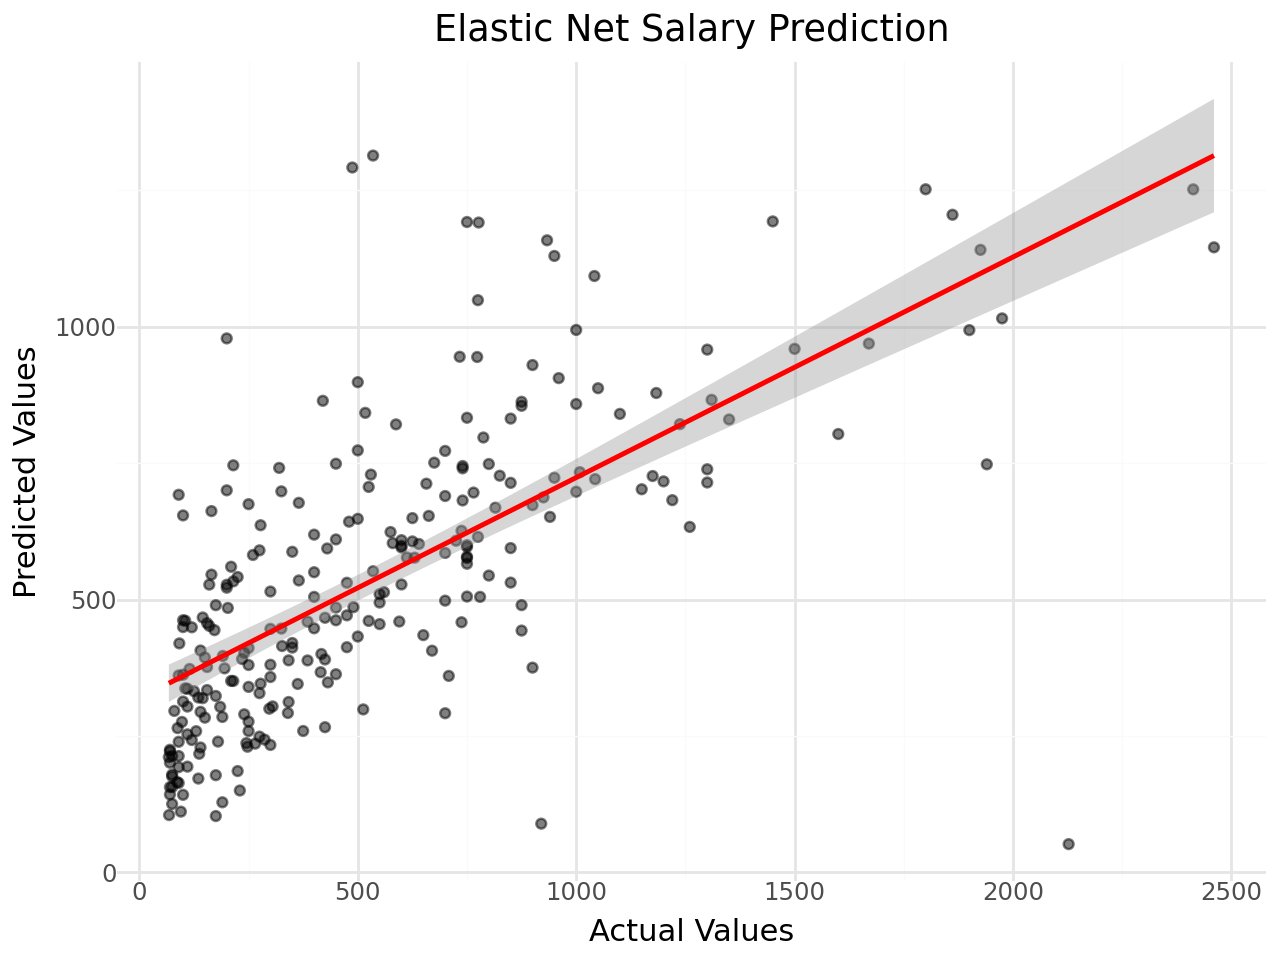

In [166]:
#plot 
from plotnine import *

plot_df = data_clean[["Salary"]].copy() 
plot_df["y_pred_en"] = y_pred_en

(ggplot(plot_df, aes(x="Salary", y="y_pred_en"))  # Use column names correctly in aes
 + geom_point(alpha = .5)
 + geom_smooth(method = "lm", color = "red")
 + labs(x="Actual Values", y="Predicted Values", title="Elastic Net Salary Prediction")
 + theme_minimal())